# Songs Popularity Prediction

## Obiettivo 
L'obiettivo di questo progetto è la creazione di un modello in grado di predire la popolarità di una canzone sulla base di alcuni suoi parametri, quali il genere, la durata e l'anno di uscita, e sulla base di alcuni parametri che riguardano l'artista che l'ha creata. 

## Dataset
Il dataset è stato reperito all'indirizzo https://www.kaggle.com/datasets/conorvaneden/best-songs-on-spotify-for-every-year-2000-2023 e contiene dati sulle 100 canzoni più popolari per ogni anno dal 2000 al 2023, per un totale di 2385 record.

## Implementazione

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Descrizione features

Carichiamo innanzitutto il dataset dal file .csv e mostriamone le prime righe.

In [72]:
songs = pd.read_csv("songs.csv", sep=";")
songs.head(10)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
5,Daylight,David Kushner,gen z singer-songwriter,2023,130,43,51,-9,9,32,213,83,3,96
6,TQG,KAROL G,reggaeton,2023,180,63,72,-4,9,61,199,67,28,96
7,Calm Down (with Selena Gomez),Rema,afrobeats,2022,107,81,80,-5,11,80,239,38,4,95
8,Anti-Hero,Taylor Swift,pop,2022,97,64,64,-7,14,53,201,13,5,94
9,Here With Me,d4vd,bedroom pop,2022,132,47,57,-8,13,29,242,53,3,94


Si noti che i record del dataset sono già ordinati per popolarità decrescente.

Notare inoltre come sia stato usato un indice numerico generato automaticamente da pandas, poiché nessun insieme di attributi può costituire una chiave primaria in questo dataset: il titolo non può esserlo perché due canzoni diverse possono ovviamente condividere lo stesso titolo, ma anche la coppia (titolo, artista) non funziona in quanto una canzone può essere rilasciata più volte (in linea teorica anche durante lo stesso anno, per quanto molto improbabile, e quindi aggiungere l'anno non aiuta).

Questa è la descrizione del significato delle variabili data dal creatore del dataset:
- Genre - the genre of the track
- Year - the release year of the recording. Note that due to vagaries of releases, re-releases, re-issues and general madness, sometimes the release years are not what you'd expect.
- Added - the earliest date you added the track to your collection.
- Beats Per Minute (BPM) - The tempo of the song.
- Energy - The energy of a song - the higher the value, the more energtic. song
- Danceability - The higher the value, the easier it is to dance to this song.
- Loudness (dB) - The higher the value, the louder the song.
- Liveness - The higher the value, the more likely the song is a live recording.
- Valence - The higher the value, the more positive mood for the song.
- Length - The duration of the song.
- Acousticness - The higher the value the more acoustic the song is.
- Speechiness - The higher the value the more spoken word the song contains.
- Popularity - The higher the value the more popular the song *currently* is.
- Duration - The length of the song.

Si faccia riferimento all'indirizzo http://organizeyourmusic.playlistmachinery.com/ per maggiori informazioni.

Nel nome delle colonne *speechiness* e *danceability* è presente uno spazio di troppo, che va rimosso.

In [73]:
songs.columns = songs.columns.str.replace('speechiness ', 'speechiness').str.replace('danceability ', 'danceability')

In [127]:
songs[songs["speechiness"] == 0]

,title,artist,year,bpm,energy,danceability,liveness,valence,duration,acousticness,...,hip-hop,indie,jazz,latin,metal,other,pop,rock,singer-songwriter,soul
1,Cupid - Twin Ver.,FIFTY FIFTY,0,120,0,3,3,3,174,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,Daylight,David Kushner,0,130,0,0,1,0,213,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,Here With Me,d4vd,1,132,0,0,2,0,242,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10,I'm Good (Blue),David Guetta,1,128,3,0,3,0,175,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez,1,101,0,0,2,0,176,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,Lips Of An Angel,Hinder,4,129,2,0,3,0,261,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2353,Under the Bridge,Project North,4,155,0,0,3,0,248,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2373,Lost Souls,KJ Hand,1,127,0,0,1,0,227,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2375,NOT AFRAID,Kodiro,1,80,0,2,1,1,180,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Analisi esplorativa

In [ ]:
corr = songs.corr(numeric_only=True)
print(abs(corr["popularity"]).sort_values(ascending=False))

popularity      1.000000
year            0.205909
energy          0.120484
acousticness    0.100588
duration        0.095590
valence         0.086720
speechiness     0.072670
bpm             0.019961
danceability    0.019491
liveness        0.019009
dB              0.004715
Name: popularity, dtype: float64


Dividiamo il dataset in variabili testuali e numeriche per effettuare una ricerca corretta.

In [ ]:
string_columns = songs.select_dtypes(include=["object"]).columns
numeric_columns = songs.select_dtypes(include=["number"]).columns

Mostriamo una bellissima scatter matrix.

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(songs[numeric_columns], figsize=(20, 20));

Mostriamo un altro bellissimo grafico.

In [ ]:
corr = songs.corr()
plt.figure(figsize=(20, 20))
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

### Integrazione del dataset con altre fonti

#### NLP

Si è ritenuto necessario aggiungere al dataset una colonna contenente i vari testi delle canzoni, il cui contenuto, opportunamente processato con tecniche di Natural Language Processing, può essere di grande aiuto per predire la popolarità di una canzone.
Si è dunque fatto uso della libreria *lyricsgenius*, che tramite l'API del sito https://genius.com/ permette di scaricare il testo di una canzone dato il titolo e l'autore.

Di seguito è possibile trovare il codice (commentato) che esegue questa operazione. Si noti tuttavia che può richiedere molto tempo (almeno un'ora) per essere eseguito, in quanto le richieste vanno spesso in timeout. Non è necessario eseguire le celle seguenti, in quanto i testi sono già stati scaricati e si trovano nel file *songs_lyrics.csv*. 

In [74]:
#%pip install lyricsgenius
#import lyricsgenius as lg

In [75]:
#import csv

#access_token = '8yvpmDv96aodI5vg660Afcby4XPdrhPrx4JCAM3souNcRYG9C2nF5TWg1'
#genius = lg.Genius(access_token)

#def get_lyrics(song_title, artist_name):
#    song = genius.search_song(song_title, artist_name)
#    return song.lyrics if song is not None else ""

#songs = pd.read_csv("songs.csv", sep=";")

#with open("songs_lyrics.csv", "a", newline="", encoding="utf-8") as csv_file:
#    writer = csv.writer(csv_file, delimiter="|")
#    writer.writerow(["title", "artist", "lyrics"])
#    for _, song in songs.iterrows():
#        is_ok = False
#        while not is_ok:
#           try:
#                lyrics = get_lyrics(song.title, song.artist)
#                is_ok = True
#                writer.writerow([song.title, song.artist, lyrics])
#            except Exception as e:
#                continue

Carichiamo e mostriamo il nuovo dataset contenente le _lyrics_ delle canzoni.

In [76]:
lyrics = pd.read_csv("songs_lyrics.csv", sep="|", na_values={"": None}, keep_default_na=False)
lyrics

,title,artist,lyrics
0,Flowers,Miley Cyrus,88 ContributorsTranslationsEspañolPortuguêsKis...
1,Cupid - Twin Ver.,FIFTY FIFTY,1 ContributorTranslationsEnglishBahasa MelayuF...
2,BESO,ROSALÍA,29 ContributorsTranslationsPortuguêsEnglishDeu...
3,Boy's a liar Pt. 2,PinkPantheress,92 ContributorsTranslationsPortuguêsTürkçeDeut...
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,2 ContributorsNew Music Friday 12/02/22 Lyrics...
...,...,...,...
2380,Southbound,Beach Blvd,2 ContributorsMe & My Skate Lyrics[Skit]\nOh s...
2381,Dance with Somebody - Radio Version,Mando Diao,1 ContributorDance With Somebody - Radio Versi...
2382,Flow,Desire Machines,1 ContributorWhat Matters? Lyrics[Hook]\nLeave...
2383,Scared of the Dark,Everything Brighter,1 ContributorWay Home LyricsYa Ya Ya\n\nI hear...


Per alcune canzoni, l'API di Genius non fornisce alcun testo.

In [77]:
lyrics[lyrics["lyrics"] == ''][:10]

,title,artist,lyrics
16,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez,
317,"Happy - From ""Despicable Me 2""",Pharrell Williams,
339,"Moves Like Jagger - Studio Recording From ""The...",Maroon 5,
446,CAN'T STOP THE FEELING! (from DreamWorks Anima...,Justin Timberlake,
684,Valerie (feat. Amy Winehouse) - Version Revisited,Mark Ronson,
686,Waka Waka (This Time for Africa) [The Official...,Shakira,
905,Free Fallin' - Live at the Nokia Theatre Los A...,John Mayer,
912,Intro,The xx,
947,Summertime Sadness (Lana Del Rey Vs. Cedric Ge...,Lana Del Rey,
1086,Jenny from the Block (feat. Jadakiss & Styles ...,Jennifer Lopez,


In generale, i testi scaricati sono "sporchi", cioè contengono messaggi da parte dell'API che però non fanno parte del testo della canzone. 

In [78]:
lyrics["lyrics"][0]

"88 ContributorsTranslationsEspañolPortuguêsKiswahiliDeutschItalianoСрпскиNederlandsSvenskaPolskiTürkçeΕλληνικάFrançaisDanskРусскийالعربيةУкраїнськаBahasa IndonesiaFlowers Lyrics[Verse 1]\nWe were good, we were gold\nKinda dream that can't be sold\nWe were right 'til we weren't\nBuilt a home and watched it burn\n\n[Pre-Chorus]\nMm, I didn't wanna leave you, I didn't wanna lie\nStarted to cry, but then remembered I\n\n[Chorus]\nI can buy myself flowers\nWrite my name in the sand\nTalk to myself for hours\nSay things you don't understand\nI can take myself dancing\nAnd I can hold my own hand\nYeah, I can love me better than you can\n\n[Post-Chorus]\nCan love me better, I can love me better, baby\nCan love me better, I can love me better, baby\n\n[Verse 2]\nPaint my nails cherry-red\nMatch the roses that you left\nNo remorse, no regret\nI forgive every word you said\nYou might also like[Pre-Chorus]\nOoh, I didn't wanna leave you, baby, I didn't wanna fight\nStarted to cry, but then rememb

Il codice seguente permette di effettuare la pulizia dei testi.

In [79]:
def clear_lyrics(text):
    return text.split("Lyrics")[1].split("Embed")[0] if text != '' and text.count(" - ") < 10 else ''

In [80]:
lyrics["lyrics"] = lyrics["lyrics"].map(clear_lyrics)
lyrics

,title,artist,lyrics
0,Flowers,Miley Cyrus,"[Verse 1]\nWe were good, we were gold\nKinda d..."
1,Cupid - Twin Ver.,FIFTY FIFTY,"[Intro: Aran]\nLa, la, la, la-la-la\nLa, la-la..."
2,BESO,ROSALÍA,"[Letra de ""BESO""]\n\n[Coro: ROSALÍA]\nYa yo ne..."
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\nTake a look inside ...
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,
...,...,...,...
2380,Southbound,Beach Blvd,"[Skit]\nOh shit God damn, I almost hit that li..."
2381,Dance with Somebody - Radio Version,Mando Diao,Break your happy home\nLearn to sing alone\nTo...
2382,Flow,Desire Machines,[Hook]\nLeave my home to chase what matters\nB...
2383,Scared of the Dark,Everything Brighter,Ya Ya Ya\n\nI hear stuff in my basement\n\nI’m...


#### Popolarità artisti su Spotify

Per trovare la popolarità di un determinato artista utilizziamo la web API fornita da Spotify. In più dobbiamo sfruttare una libreria fatta apposta per interfacciarsi con l'API tramite Python.

Spotify Web API: https://developer.spotify.com/documentation/web-api

Libreria Spotipy: https://spotipy.readthedocs.io/en/2.22.1/#

In [ ]:
%pip install spotipy
import spotipy as sp

Impostiamo le credenziale per lavorare con la API di Spotify. Saranno nascoste per motivi di protezione

In [ ]:
client_id = ''
client_secret = ''

Stabiliamo una connessione con Spotify

In [ ]:
spotify = sp.Spotify(client_credentials_manager=sp.oauth2.SpotifyClientCredentials(client_id, client_secret))

Definiamo una funzione per trovare la popolarità di un artista in base al nome

In [ ]:
def get_artist_popularity(artist_name):
    results = spotify.search(q='artist:' + artist_name, type='artist')
    items = results['artists']['items']
    return items[0]['popularity'] if len(items) > 0 else np.nan

Carichiamo in un nuovo file csv i nomi degli artisti associati alla loro popolarità prendendo i nomi dal dataset delle canzoni.

La popolarità è un numero da 1 a 100 calcolato da Spotify utilizzando un algoritmo interno che si basa sul numero di ascolti pesati in base alla loro vicinanza al presente

In [ ]:
with open("artist_popularity.csv", "a", newline="", encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file, delimiter="|")
    writer.writerow(["artist", "popularity"])
    for _, song in songs.iterrows():
        is_ok = False
        while not is_ok:
            try:
                popularity = get_artist_popularity(song.artist)
                is_ok = True
                writer.writerow([song.artist, popularity])
            except Exception as e:
                continue
    

Leggiamo poi il file csv creato e ne carichiamo i dati su un Dataset, eliminando i duplicati e ordinando per popolarità

In [ ]:
artist_popularity = pd.read_csv("artist_popularity.csv", sep="|")
artist_popularity.drop_duplicates(subset="artist", inplace=True)
artist_popularity.reset_index(drop=True, inplace=True)
artist_popularity.sort_values(by="popularity", ascending=False, inplace=True)
artist_popularity.head(20)

,artist,popularity
8,Taylor Swift,100.0
18,Bad Bunny,96.0
12,The Weeknd,95.0
22,Drake,95.0
4,Metro Boomin,91.0
101,Lana Del Rey,91.0
19,Eminem,90.0
126,21 Savage,90.0
35,Ed Sheeran,90.0
135,BTS,90.0


### Preparazione dataset

Dato che il dataset calcola la popolarità attuale, convertiamo l'anno di uscita come distanza dal 2023.

In [85]:
songs["year"] = 2023 - songs["year"]

Analizziamo le relazioni fra le variabili numeriche plottando una matrice di scatter

Creazione di un dizionario che associa i macro generi ai generi che ne fanno parte

In [87]:
dict_genre = {
    "pop": ["pop", "boy band", "idol"],
    "rock": ["rock"],
    "hip-hop": ["hip", "rap", "drill", "sad lo-fi"],
    "soul": ["r&b", "soul", "gospel"],
    "metal": ["metal"],
    "latin": ["reggae", "Latin"],
    "edm": ["house", "edm", "electro", "dance", "techno", "dubstep", "brostep"],
    "indie": ["indie", "folk", "alternative"],
    "singer-songwriter": ["singer-songwriter"],
    "jazz": ["jazz"]
}

Creazione di una funzione per selezionare i generi che non appartengono a nessuna delle categorie sopra elencate

In [88]:
def get_genres(genres):
    return [Other(genre) for genre in genres]
def Other(genre):
    return genre not in dict_genre.keys()



ogni micro-categoria che appartiene alle macro categorie rappresentate nel dizionario, viene sostituita con la macro categoria corrispondente, per quanto riguarda le altre categorie, vengono sostituite con la categoria other

In [89]:
genre = songs["top genre"]

for key in dict_genre.keys():
	for value in dict_genre[key]:
		genre[genre.str.contains(value.lower())] = key

genre[get_genres(genre)] = "other"


C:\Users\sirri\AppData\Local\Temp\ipykernel_2828\3521248662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre[genre.str.contains(value.lower())] = key
C:\Users\sirri\AppData\Local\Temp\ipykernel_2828\3521248662.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre[get_genres(genre)] = "other"


Stampa dei vari generi ottenuti, con il numero di canzoni per genere

In [90]:
genre.value_counts()

pop                  1104
hip-hop               454
other                 244
edm                   183
soul                  154
rock                  109
metal                  60
indie                  35
latin                  34
singer-songwriter       6
jazz                    2
Name: top genre, dtype: int64

Assegnamento nel dataset delle canzoni della colonna creata precedentemente

In [91]:
songs["top genre"] = genre

In [92]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
genre_one_hot = encoder.fit_transform(songs[["top genre"]])
genre_one_hot = pd.DataFrame(genre_one_hot, columns=encoder.categories_[0])
songs = pd.concat([songs, genre_one_hot], axis=1)
songs.drop(["top genre"], axis=1, inplace=True)
songs.corr()["popularity"].sort_values(ascending=False)



c:\Users\sirri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\sirri\AppData\Local\Temp\ipykernel_2828\762320974.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  songs.corr()["popularity"].sort_values(ascending=False)


popularity           1.000000
songs of artist      0.241812
acousticness         0.100588
latin                0.096684
rock                 0.069916
pop                  0.052410
singer-songwriter    0.047534
metal                0.031049
hip-hop              0.026465
jazz                 0.007545
liveness            -0.019009
danceability        -0.019491
bpm                 -0.019961
soul                -0.043647
other               -0.066467
speechiness         -0.072670
valence             -0.086720
edm                 -0.092357
duration            -0.095590
energy              -0.120484
indie               -0.121375
year                -0.205909
Name: popularity, dtype: float64

Trasformazione di alcune variabili numeriche in categoriche.

In [94]:
songs.groupby(pd.cut(songs['danceability'], [0, 60, 68, 76, 100])).size()
	

danceability
(0, 60]      691
(60, 68]     544
(68, 76]     552
(76, 100]    598
dtype: int64

In [95]:
songs['danceability'] = pd.cut(songs['danceability'], bins=[
                               0, 60, 68, 76, 100], labels=[0, 1, 2, 3])


In [96]:
songs.energy.max()

100

In [97]:
songs.groupby(pd.cut(songs['energy'], [0, 60, 72, 82, 100])).size()

energy
(0, 60]      639
(60, 72]     615
(72, 82]     565
(82, 100]    566
dtype: int64

In [98]:
songs.energy.max()


100

In [99]:
songs['energy'] = pd.cut(songs['energy'], bins=[
    0, 60, 72, 82, 100], labels=[0, 1, 2, 3])


In [100]:
songs.groupby(pd.cut(songs['liveness'], [0, 8, 11, 20, 100])).size()


liveness
(0, 8]       511
(8, 11]      553
(11, 20]     640
(20, 100]    681
dtype: int64

In [101]:
songs.liveness.max()

84

In [102]:
songs['liveness'] = pd.cut(songs['liveness'], bins=[
    0, 8, 11, 20, 100], labels=[0, 1, 2, 3])


In [103]:
songs.valence.max()

97

In [104]:
songs.groupby(pd.cut(songs['valence'], [0, 40, 55, 72, 100])).size()


valence
(0, 40]      696
(40, 55]     552
(55, 72]     538
(72, 100]    599
dtype: int64

In [105]:
songs['valence'] = pd.cut(songs['valence'], bins=[
    0, 40, 55, 72, 100], labels=[0, 1, 2, 3])


In [106]:
songs.columns

Index(['title', 'artist', 'year', 'bpm', 'energy', 'danceability', 'liveness',
       'valence', 'duration', 'acousticness', 'speechiness', 'popularity',
       'songs of artist', 'edm', 'hip-hop', 'indie', 'jazz', 'latin', 'metal',
       'other', 'pop', 'rock', 'singer-songwriter', 'soul'],
      dtype='object')

In [107]:
songs.acousticness.max()

98

In [108]:
songs.groupby(pd.cut(songs['acousticness'], [0, 3, 9, 25, 100])).size()


acousticness
(0, 3]       546
(3, 9]       508
(9, 25]      523
(25, 100]    503
dtype: int64

In [109]:
songs['acousticness'] = pd.cut(songs['acousticness'], bins=[
    0, 3, 9, 25, 100], labels=[0, 1, 2, 3])


In [110]:
songs.speechiness.max()

58

<Axes: >

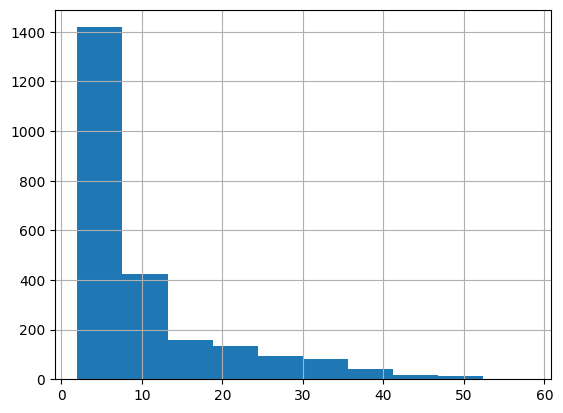

In [111]:
songs.speechiness.hist()

In [112]:
songs.groupby(pd.cut(songs['speechiness'], [0, 3, 5, 10, 58])).size()


speechiness
(0, 3]      433
(3, 5]      687
(5, 10]     570
(10, 58]    695
dtype: int64

In [113]:
def create_bins(feature_name, bins):
    return pd.cut(songs[feature_name], bins=bins, labels=range(len(bins-1)))

In [123]:
songs.speechiness.value_counts()

3    695
1    687
2    570
0    433
Name: speechiness, dtype: int64

In [115]:
songs["speechiness"] = create_bins("speechiness", bins=[0, 25, 100])

In [116]:
songs.popularity.max()

98

In [117]:
songs.groupby(pd.cut(songs['popularity'], [0, 65, 72, 78, 100])).size()


popularity
(0, 65]      695
(65, 72]     562
(72, 78]     516
(78, 100]    612
dtype: int64

In [118]:
songs['popularity'] = pd.cut(songs['popularity'], bins=[
    0, 65, 72, 78, 100], labels=[0, 1, 2, 3])


In [119]:
songs

,title,artist,year,bpm,energy,danceability,liveness,valence,duration,acousticness,...,hip-hop,indie,jazz,latin,metal,other,pop,rock,singer-songwriter,soul
0,Flowers,Miley Cyrus,0,118,1,2,0,2,200,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Cupid - Twin Ver.,FIFTY FIFTY,0,120,0,3,3,3,174,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,BESO,ROSALÍA,0,95,1,3,2,1,195,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Boy's a liar Pt. 2,PinkPantheress,0,133,2,2,3,3,131,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,1,98,1,2,0,0,222,3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,Southbound,Beach Blvd,0,140,3,0,1,1,228,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2381,Dance with Somebody - Radio Version,Mando Diao,14,150,3,0,3,1,241,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2382,Flow,Desire Machines,1,100,3,0,1,3,255,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2383,Scared of the Dark,Everything Brighter,0,120,2,1,0,2,179,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
